In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_generator = image_dataset_from_directory(
    './dataset/train/',
    image_size=(224, 224),
    batch_size=16,
    label_mode='binary'
)

Found 557 files belonging to 2 classes.


2024-06-15 09:28:00.870283: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-15 09:28:00.870304: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-15 09:28:00.870313: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-15 09:28:00.870336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 09:28:00.870350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
train_size = int(0.8 * len(train_generator))

train_data = train_generator.take(train_size)
val_data = train_generator.skip(train_size)

In [4]:
train_size

28

In [5]:
val_generator = image_dataset_from_directory(
    './dataset/test/',
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)

Found 140 files belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
history = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[early_stopping, reduce_lr])

Epoch 1/50


2024-06-15 09:28:11.595224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.8208 - loss: 0.3581 - val_accuracy: 0.9450 - val_loss: 0.2340 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9718 - loss: 0.1056 - val_accuracy: 0.9725 - val_loss: 0.1409 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9362 - loss: 0.1322 - val_accuracy: 0.9817 - val_loss: 0.0867 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.9612 - loss: 0.0799 - val_accuracy: 0.9358 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9798 - loss: 0.0522 - val_accuracy: 0.9633 - val_loss: 0.2184 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9716 - loss: 0.0688 - val_accuracy: 0.9817 - val_loss: 0.0441 - learning_rate: 3.0000e-04
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9822 - loss: 0.0455 - val_accuracy: 0.9908

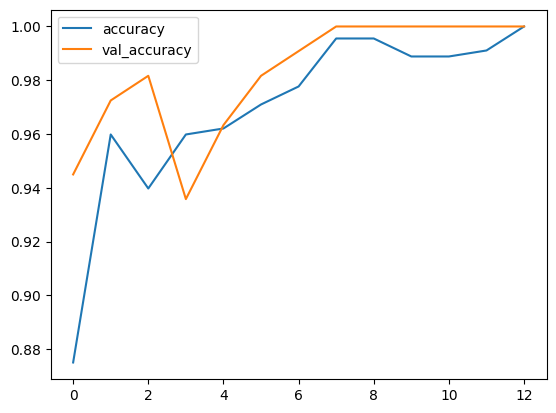

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

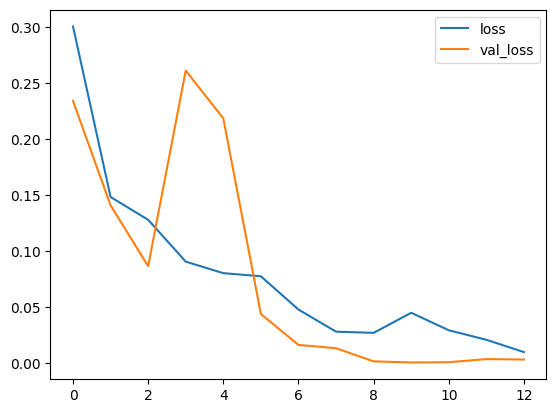

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [13]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

In [14]:
test_images = []
test_labels = []
import tensorflow_datasets as tfds
for n in tfds.as_numpy(val_generator):
    test_images.extend(n[0])
    test_labels.extend(n[1])

2024-06-15 09:45:13.135652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
np_test_images = np.array(test_images)
np_test_labels = np.array(test_labels)

In [16]:
pred = model.predict(np_test_images)
pred_labels = [0 if l < 0.5 else 1 for l in pred]

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step 


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
print( classification_report(test_labels, pred_labels) )

              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86        70
         1.0       0.83      0.93      0.88        70

    accuracy                           0.87       140
   macro avg       0.88      0.87      0.87       140
weighted avg       0.88      0.87      0.87       140



In [19]:
print (confusion_matrix(test_labels, pred_labels))

[[57 13]
 [ 5 65]]


In [20]:
img = load_and_preprocess_image('./internet_images/chrissy-bogomilova-H-IkEgzJb-M-unsplash.jpg')
imgb = np.expand_dims(img, axis=0)

In [21]:
pred = model.predict(imgb)
clas = 'cat' if pred[0] < 0.5 else 'dog'

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


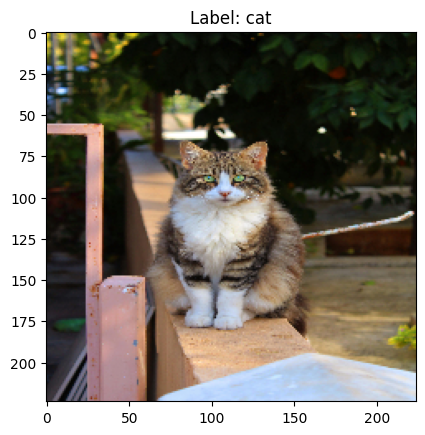

In [22]:
plt.imshow(img)
plt.title(f"Label: {clas}")
plt.show()

In [23]:
img = load_and_preprocess_image('./dataset/test/cats/cat_464.jpg')
imgb = np.expand_dims(img, axis=0)

In [24]:
pred = model.predict(imgb)
clas = 'cat' if pred[0] < 0.5 else 'dog'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


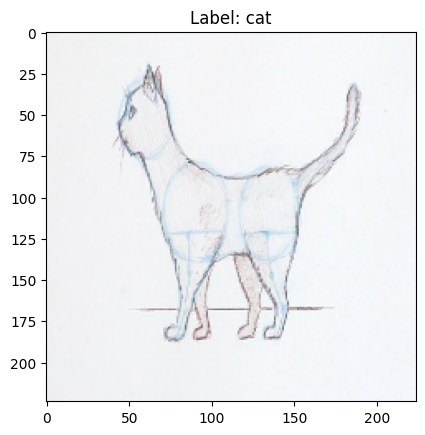

In [25]:
plt.imshow(img)
plt.title(f"Label: {clas}")
plt.show()